# Reinforcement Learning

## Abstract
Reinforcement Learning(RL) is a type of machine learning technique that enables an agent to learn in an interactive environment by trial and error using feedback from its own actions and experiences.
Reinforcement learning is learning what to do—how to map situations to actions—so as to maximize a numerical reward signal. The learner is not told which actions to take, but instead must discover which actions yield the most reward by trying them.
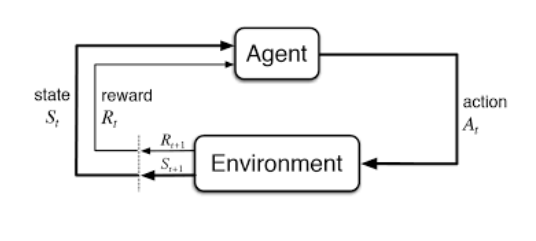

Reinforcement learning, due to its generality, is studied in many other disciplines, such as game theory, control theory, operations research, information theory, simulation-based optimization, multi-agent systems, swarm intelligence, statistics and genetic algorithms. In the operations research and control literature, reinforcement learning is called approximate dynamic programming, or neuro-dynamic programming. The problems of interest in reinforcement learning have also been studied in the theory of optimal control, which is concerned mostly with the existence and characterization of optimal solutions, and algorithms for their exact computation, and less with learning or approximation, particularly in the absence of a mathematical model of the environment. In economics and game theory, reinforcement learning may be used to explain how equilibrium may arise under bounded rationality.

In this notebook, I will present an implementation of the Q-learning algorithm and apply it to the "Taxi-v3" [AI Gym Environment](https://gym.openai.com/)

## Q-Learning (Taxi-v3)
Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.
The ‘q’ in q-learning stands for quality. Quality in this case represents how useful a given action is in gaining some future reward.


In [104]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Environment - OpenAi Gym's Taxi-V3

This task was introduced in [Dietterich2000] to illustrate some issues in hierarchical reinforcement learning. There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

[Dietterich2000]	T Erez, Y Tassa, E Todorov, "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition", 2011.

In [105]:
env = gym.make("Taxi-v3") #Creating the environment
env.render()              #Rendering the environment

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Q-table
In Q-learning the goal is to learn a policy that will tell an agent which action to take under each possible state. The Q-table is responsible to store score values for each (state, action) pair. These values can be initialized with zeros or randomly, and them they are updated as you perform exploration in your problem domain (which helps to discover which actions leads to a better stream of rewards)

In [106]:
action_size = env.action_space.n
print("Action size ", action_size)

state_size = env.observation_space.n
print("State size ", state_size)

Action size  6
State size  500


In [107]:
qtable = np.zeros((state_size, action_size))
print(qtable)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


## Hyperparameters

The hyperparameters used in the Q-value update process are:

Learning Rate: lr or learning rate, often referred to as alpha or α, can simply be defined as how much you accept the new value vs the old value. Above we are taking the difference between new and old and then multiplying that value by the learning rate. This value then gets added to our previous q-value which essentially moves it in the direction of our latest update.

Gamma: gamma or γ is a discount factor. It’s used to balance immediate and future reward. From our update rule above you can see that we apply the discount to the future reward. 

Reward: reward is the value received after completing a certain action at a given state. A reward can happen at any given time step or only at the terminal time step.

In [108]:
total_episodes = 5000         # Total episodes
total_test_episodes = 100     # Total test episodes
max_steps = 99                # Max steps per episode

learning_rate = 0.7           # Learning rate
gamma = 0.8                   # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.01             # Exponential decay rate for exploration prob

## Exploration (Q-learning)
Since the goal here is to learn the optimal q-table, that is, best policy for each (state,action) pair: we need to perform exploration only. If the goal was to learn and solve the environment as quickly as possible, it would be necessary to implement an exploration-exploitation strategy. This kind of strategy would not work for this goal since we want to discover the optimal values for states that would not often/never be visited via the exploration-exploitation strategy.

The exploration strategy here implemented is straightforward: for each state we get to, take an action randomly. The randomness "guarantees" that we are going to visit each state action pair eventually.

In [109]:
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0,1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
        
        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * 
                                    np.max(qtable[new_state, :]) - qtable[state, action])
                
        # Our new state is state
        state = new_state
        
        # If done : finish episode
        if done == True: 
            break
    
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

In [115]:
env.reset()
rewards = []
count0 = []
count = 0

for episode in range(total_test_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
        env.render()
        count = count+1
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            count0.append(count)
            print ("Score", total_rewards)
            count = 0
            break
        state = new_state
env.close()
print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

****************************************************
EPISODE  0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+------

  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Score 8
****************************************************
EPISODE  86
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------

In [99]:
np.mean(count0)

12.71



## Toggling the values of the Learning Rate and the Gamma and then analyzing the results
Now i will try to toggle the hyperparameters a little. The below code changed the values of the learning parameter and gamma continuously with an interval of 0.1.

In [14]:
l = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
lr = []
g = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
ga = []
score = []
for learning_rate in l:
    
    for gamma in g:

        # 2 For life or until learning is stopped
        for episode in range(total_episodes):
            # Reset the environment
            state = env.reset()
            step = 0
            done = False

            for step in range(max_steps):
                # 3. Choose an action a in the current world state (s)
                ## First we randomize a number
                exp_exp_tradeoff = random.uniform(0,1)

                ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
                if exp_exp_tradeoff > epsilon:
                    action = np.argmax(qtable[state,:])

                # Else doing a random choice --> exploration
                else:
                    action = env.action_space.sample()

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, done, info = env.step(action)

                # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * 
                                            np.max(qtable[new_state, :]) - qtable[state, action])

                # Our new state is state
                state = new_state

                # If done : finish episode
                if done == True: 
                    break

            # Reduce epsilon (because we need less and less exploration)
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        env.reset()
        rewards = []
        count0 = []
        count = 0

        for episode in range(total_test_episodes):
            state = env.reset()
            step = 0
            done = False
            total_rewards = 0
            #print("****************************************************")
            #print("EPISODE ", episode)

            for step in range(max_steps):
                # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
                #env.render()
                count = count+1
                # Take the action (index) that have the maximum expected future reward given that state
                action = np.argmax(qtable[state,:])

                new_state, reward, done, info = env.step(action)

                total_rewards += reward

                if done:
                    rewards.append(total_rewards)
                    count0.append(count)
                    #print ("Score", total_rewards)
                    count = 0
                    break
                state = new_state
        env.close()
        score0 = sum(rewards)/total_test_episodes
        score.append(score0)
        lr.append(learning_rate)
        ga.append(gamma)
        print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

Score over time: 0.44
Score over time: 3.03
Score over time: 4.52
Score over time: 4.91
Score over time: 5.47
Score over time: 5.68
Score over time: 7.44
Score over time: 7.8
Score over time: 7.88
Score over time: 8.34
Score over time: 7.33
Score over time: 8.47
Score over time: 8.0
Score over time: 7.96
Score over time: 7.1
Score over time: 7.83
Score over time: 7.66
Score over time: 7.62
Score over time: 7.83
Score over time: 7.58
Score over time: 7.7
Score over time: 8.06
Score over time: 7.95
Score over time: 7.62
Score over time: 8.08
Score over time: 8.08
Score over time: 7.5
Score over time: 8.09
Score over time: 7.82
Score over time: 7.75
Score over time: 7.82
Score over time: 7.62
Score over time: 7.61
Score over time: 8.39
Score over time: 7.51
Score over time: 7.79
Score over time: 7.65
Score over time: 7.75
Score over time: 8.02
Score over time: 7.62
Score over time: 8.31
Score over time: 7.75
Score over time: 7.45
Score over time: 8.13
Score over time: 7.64
Score over time

In [49]:
dict1 = {'Learning Rate': lr,
      'Gamma': ga,
      'Score': score}
df1 = pd.DataFrame(data=dict1)
df1.head(5)

,Learning Rate,Gamma,Score
0,0.1,0.1,7.80
1,0.1,0.2,8.18
2,0.1,0.3,8.54
3,0.1,0.4,8.00
4,0.1,0.5,7.93


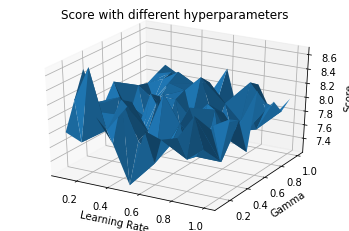

In [51]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = df1['Learning Rate']
y = df1['Gamma']
z = df1['Score']
ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
ax.set_xlabel('Learning Rate', fontsize=10, rotation=150)
ax.set_ylabel('Gamma')
ax.set_zlabel(r'Score', fontsize=10, rotation=60)
ax.set_title('Score with different hyperparameters')
plt.show()

## Trying a policy other than maxQ(s', a') and analyzing the results

### Min 
Minimum instead of Maximum gives a score of 3.97

In [9]:
#Trying something other than max(q,a) - min here
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0,1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
        
        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * 
                                    np.min(qtable[new_state, :]) - qtable[state, action])
                
        # Our new state is state
        state = new_state
        
        # If done : finish episode
        if done == True: 
            break
    
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
env.reset()
rewards = []
count0 = []
count = 0

for episode in range(total_test_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
        #env.render()
        count = count+1
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            count0.append(count)
            print ("Score", total_rewards)
            count = 0
            break
        state = new_state
env.close()
print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

****************************************************
EPISODE  0
Score 9
****************************************************
EPISODE  1
Score 9
****************************************************
EPISODE  2
Score 7
****************************************************
EPISODE  3
Score 11
****************************************************
EPISODE  4
Score 6
****************************************************
EPISODE  5
****************************************************
EPISODE  6
****************************************************
EPISODE  7
Score 9
****************************************************
EPISODE  8
****************************************************
EPISODE  9
Score 8
****************************************************
EPISODE  10
****************************************************
EPISODE  11
****************************************************
EPISODE  12
****************************************************
EPISODE  13
*******************************************

### Sum
Sum gives a score of 1.96

In [10]:
#Trying something other than max(q,a) - min here
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0,1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
        
        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * 
                                    np.sum(qtable[new_state, :]) - qtable[state, action])
                
        # Our new state is state
        state = new_state
        
        # If done : finish episode
        if done == True: 
            break
    
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
env.reset()
rewards = []
count0 = []
count = 0

for episode in range(total_test_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
        #env.render()
        count = count+1
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            count0.append(count)
            print ("Score", total_rewards)
            count = 0
            break
        state = new_state
env.close()
print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

****************************************************
EPISODE  0
****************************************************
EPISODE  1
****************************************************
EPISODE  2
****************************************************
EPISODE  3
****************************************************
EPISODE  4
****************************************************
EPISODE  5
****************************************************
EPISODE  6
****************************************************
EPISODE  7
****************************************************
EPISODE  8
****************************************************
EPISODE  9
****************************************************
EPISODE  10
****************************************************
EPISODE  11
Score 10
****************************************************
EPISODE  12
Score 13
****************************************************
EPISODE  13
Score 9
****************************************************
EPISODE  14
*********

### Median
Median gives a score of 3.39

In [11]:
#Trying something other than max(q,a) - min here
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0,1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
        
        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * 
                                    np.median(qtable[new_state, :]) - qtable[state, action])
                
        # Our new state is state
        state = new_state
        
        # If done : finish episode
        if done == True: 
            break
    
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
env.reset()
rewards = []
count0 = []
count = 0

for episode in range(total_test_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
        #env.render()
        count = count+1
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            count0.append(count)
            print ("Score", total_rewards)
            count = 0
            break
        state = new_state
env.close()
print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

****************************************************
EPISODE  0
****************************************************
EPISODE  1
Score 8
****************************************************
EPISODE  2
Score 8
****************************************************
EPISODE  3
****************************************************
EPISODE  4
****************************************************
EPISODE  5
Score 8
****************************************************
EPISODE  6
****************************************************
EPISODE  7
****************************************************
EPISODE  8
Score 14
****************************************************
EPISODE  9
****************************************************
EPISODE  10
Score 8
****************************************************
EPISODE  11
Score 3
****************************************************
EPISODE  12
Score 10
****************************************************
EPISODE  13
******************************************

### Standard Deviation
Provides the worst performance with a score of 0.0

In [13]:
#Trying something other than max(q,a) - min here
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0,1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
        
        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * 
                                    np.std(qtable[new_state, :]) - qtable[state, action])
                
        # Our new state is state
        state = new_state
        
        # If done : finish episode
        if done == True: 
            break
    
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
env.reset()
rewards = []
count0 = []
count = 0

for episode in range(total_test_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
        #env.render()
        count = count+1
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            count0.append(count)
            print ("Score", total_rewards)
            count = 0
            break
        state = new_state
env.close()
print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

****************************************************
EPISODE  0
****************************************************
EPISODE  1
****************************************************
EPISODE  2
****************************************************
EPISODE  3
****************************************************
EPISODE  4
****************************************************
EPISODE  5
****************************************************
EPISODE  6
****************************************************
EPISODE  7
****************************************************
EPISODE  8
****************************************************
EPISODE  9
****************************************************
EPISODE  10
****************************************************
EPISODE  11
****************************************************
EPISODE  12
****************************************************
EPISODE  13
****************************************************
EPISODE  14
***********************************

In [116]:
d = {'Policy': ['Maximum','Minimum','Sum','Median','Standard Deviation'], 'Score': [7.29,3.97,1.96,3.39,0.0]}
df = pd.DataFrame(data=d)
df

,Policy,Score
0,Maximum,7.29
1,Minimum,3.97
2,Sum,1.96
3,Median,3.39
4,Standard Deviation,0.00


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

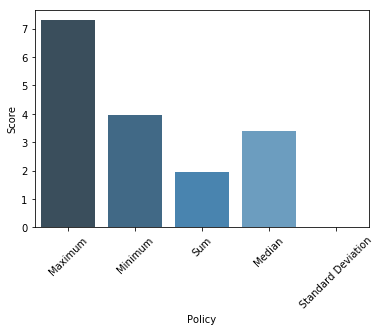

In [117]:
sns.barplot(x = df['Policy'],y = df['Score'], data = df, palette="Blues_d")
plt.xticks(rotation=45)

The above plot clearly shows that max function provides the best result after all.

## Toggling the Epsilon and Decay Rate

In [30]:
e = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
ep = []
d = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
dr = []
score = []
for epsilon in e:
    
    for decay_rate in d:

        # 2 For life or until learning is stopped
        for episode in range(total_episodes):
            # Reset the environment
            state = env.reset()
            step = 0
            done = False

            for step in range(max_steps):
                # 3. Choose an action a in the current world state (s)
                ## First we randomize a number
                exp_exp_tradeoff = random.uniform(0,1)

                ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
                if exp_exp_tradeoff > epsilon:
                    action = np.argmax(qtable[state,:])

                # Else doing a random choice --> exploration
                else:
                    action = env.action_space.sample()

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, done, info = env.step(action)

                # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * 
                                            np.max(qtable[new_state, :]) - qtable[state, action])

                # Our new state is state
                state = new_state

                # If done : finish episode
                if done == True: 
                    break

            # Reduce epsilon (because we need less and less exploration)
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        env.reset()
        rewards = []
        count0 = []
        count = 0

        for episode in range(total_test_episodes):
            state = env.reset()
            step = 0
            done = False
            total_rewards = 0
            #print("****************************************************")
            #print("EPISODE ", episode)

            for step in range(max_steps):
                # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
                #env.render()
                count = count+1
                # Take the action (index) that have the maximum expected future reward given that state
                action = np.argmax(qtable[state,:])

                new_state, reward, done, info = env.step(action)

                total_rewards += reward

                if done:
                    rewards.append(total_rewards)
                    count0.append(count)
                    #print ("Score", total_rewards)
                    count = 0
                    break
                state = new_state
        env.close()
        score0 = sum(rewards)/total_test_episodes
        score.append(score0)
        ep.append(epsilon)
        dr.append(decay_rate)
        print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

Score over time: 7.8
Score over time: 8.18
Score over time: 8.54
Score over time: 8.0
Score over time: 7.93
Score over time: 8.16
Score over time: 7.56
Score over time: 7.86
Score over time: 7.79
Score over time: 7.68
Score over time: 7.7
Score over time: 8.67
Score over time: 7.98
Score over time: 7.53
Score over time: 8.05
Score over time: 7.73
Score over time: 8.08
Score over time: 8.04
Score over time: 8.11
Score over time: 8.17
Score over time: 8.1
Score over time: 7.84
Score over time: 7.99
Score over time: 7.85
Score over time: 7.56
Score over time: 7.73
Score over time: 7.91
Score over time: 8.14
Score over time: 8.17
Score over time: 8.05
Score over time: 7.77
Score over time: 8.31
Score over time: 8.21
Score over time: 7.66
Score over time: 8.18
Score over time: 8.07
Score over time: 8.19
Score over time: 8.28
Score over time: 7.33
Score over time: 7.79
Score over time: 7.22
Score over time: 7.78
Score over time: 7.84
Score over time: 8.18
Score over time: 7.8
Score over time

In [32]:
dict2 = {'Epsilon': ep,
      'Decay Rate': dr,
      'Score': score}
df2 = pd.DataFrame(data=dict2)
df2.head(5)

,Epsilon,Decay Rate,Score
0,0.01,0.1,7.80
1,0.01,0.2,8.18
2,0.01,0.3,8.54
3,0.01,0.4,8.00
4,0.01,0.5,7.93


## Part 1

#### 1. Establish a baseline performance. How well did your RL Q-learning do on your problem?
A. The baseline performance is as defined in the Assignment notebook.
total_episodes = 5000       
total_test_episodes = 100   
max_steps = 99              
learning_rate = 0.7         
gamma = 0.8                 
epsilon = 1.0               
max_epsilon = 1.0           
min_epsilon = 0.01           
decay_rate = 0.01
With this baseline performance, our RL program with the Taxi-v2 Toy text gives us a score of 8.13 which is considerably not bad.


#### 2. What are the states, the actions and the size of the Q-table?
A. With the code snippet below :-
action_size = env.action_space.n
print("Action size ", action_size)

state_size = env.observation_space.n
print("State size ", state_size)

We find out that the Action size is 6 and the state size is 500. The size of the Q-table is 6 x 500.


#### 3. What are the rewards? Why did you choose them? 
A. The rewards system in our program is that the agent will receive 20 points for a dropoff, 1 point for each timestep to push our agent to be faster and -1 point for each illegal dropoff and pickup.


#### 4. How did you choose alpha and gamma in the following equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?
A. The overall aim in reinforcement Learning is that we are trying to find the optimal action for any given state whilst achieving this in a reasonable number of effort (measured by the number of episodes, computation needed or time). A good explanation for the learning rate is that a high value means we value the information gained in each action more and so learn faster but may find it hard to full converge whilst a small value will take longer but will steadily converge. That's why we chose an alpha of 0.7.
If we take a high gamma value, we consider the information obtained from this next state to be more important. And that's how we chose a gamma of 0.8
Increasing the value of the learning rate and decreasing the gamma gave us a score of 8.4 which is better than the previous score. Toggling these parameters will give us quite different results every time.


#### 5. Try a policy other than maxQ(s', a'). How did it change the baseline performance?
A. Minimum in place of maximum decreased the score significantly as expected and dropped from 7.29 to 3.97.
sum did the same and decreased it more than min already and the score dropped to 1.96.
Median gave a score of 3.39 which is better than the sum but still doesn't surpass the minimum.
std as expected gave the worst results with the score of 0.0.


#### 6. How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode? 
A. Epsilon marks the trade-off between exploration and exploitation. At the beginning, you want epsilon to be high so that you take big leaps and learn things. Here we wanted our agent to explore the environment more than exploit it so we chose the epsilon value as 1.0. As you learn about future rewards, epsilon should decay so that you can exploit the higher Q-values you've found. Hence we set the decay rate as 0.01. Changing the value of Epsilon and Decay rate has a significant impact on our score as we can see from its implementation. With the exploration-exploitation tradeoff, the agent behaves accordingly as we set our parameters.


#### 7. What is the average number of steps taken per episode?
A. 13.76


#### 8. Does Q-learning use value-based or policy-based iteration?
A. Q-Learning is an Off-Policy based algorithm for Temporal Difference learning. It can be proven that given sufficient training under any epsilon-soft policy, the algorithm converges with probability 1 to a close approximation of the action-value function for an arbitrary target policy. Q-Learning learns the optimal policy even when actions are selected according to a more exploratory or even random policy. 


#### 9. What is meant by expected lifetime value in the Bellman equation?
A. In the Bellman Equation, we assume that the expected lifetime value suggests the value for which the episode in an algorithm is kept running to accumulate the score over time. In the Bellman equation, the value function Φ(t) depends on the value function Φ(t+1). Despite this, the value of Φ(t) can be obtained before the state reaches time t+1.

## Part 2

With the baseline hyperparameters provided before, we get a score of 7.29. So a 2% increase from this score would be a score higher than 8.068. After toggling the hyperparamenters, we can look for a score higher than that in the dataframes we created earlier.

#### With the df1 dataframe which toggled with the learning rate and gamma hyperparameters, We get the score 8.67 which is the highest score that has a 17.29323% increase from the previous baseline score

In [64]:
#df1[df1['Score']>8.068]
df1.loc[df1['Score'].idxmax()]

Learning Rate    0.20
Gamma            0.20
Score            8.67
Name: 11, dtype: float64

#### And with the df2 dataframe which toggled with the Epsilon and Decay Rate hyperparameters,  We get the score 8.67 which is the highest score that has a 17.29323% increase from the previous baseline score

In [96]:
#df2[df2['Score']>8.068]
df2.loc[df2['Score'].idxmax()]

Epsilon       0.01
Decay Rate    0.20
Score         8.67
Name: 11, dtype: float64

## Results
With the above notebook we have tried to implement some basic concepts of Q-Learning to OpenAi Gym's Taxi-V3 toy text. We get 
promising results with our baseline parameters and then better results after tuning the Hyperparameters some more. We notice that toggling the parameters to their optimal values has a significant effect on the score obtained by the agent in the end. We also conclude that max(s,a) is the best option to obtain good results rather than any other aggregate function.

## References

[OpenAI Gym](https://gym.openai.com/)

[Q-Learning - 1](https://www.youtube.com/watch?v=q2ZOEFAaaI0&t=626s)

[Q-Learning - 2](https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html)

[Reinforcement Learning Overview -1](https://en.wikipedia.org/wiki/Reinforcement_learning)

[Reinforcement Learning Overview -1](https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56)

[3-D Plot](https://matplotlib.org/examples/mplot3d/trisurf3d_demo.html)

[Hyperparameter Tuning](https://towardsdatascience.com/reinforcement-learning-from-scratch-simple-application-and-evaluating-parameters-in-detail-2dcee3de008c)

[Reinforcement Learning Complete](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)

[Bellman Equation](https://towardsdatascience.com/how-the-bellman-equation-works-in-deep-reinforcement-learning-5301fe41b25a)


## License

MIT License

Copyright (c) 2020 Krisha Shah

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.